In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import joblib
from google.cloud import aiplatform
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
import numpy as np
import spacy

These are the important libraries that we are using in this project. Scikit learn for the model, Pandas and numpy for data manipulation and wordcloud and spacy for word cleanup

In [2]:
file_path_test = '../medical_cases_test.csv'
df_test = pd.read_csv(file_path_test)
print("✅ Successfully loaded the test dataset.")
print("Dataset preview:")
print(df_test.head())

file_path_train = '../medical_cases_train.csv'
df_train = pd.read_csv(file_path_train)
print("✅ Successfully loaded the train dataset.")
print("Dataset preview:")
print(df_train.head())

file_path_validation = '../medical_cases_validation.csv'
df_validation = pd.read_csv(file_path_validation)
print("✅ Successfully loaded the validation dataset.")
print("Dataset preview:")
print(df_validation.head())

✅ Successfully loaded the test dataset.
Dataset preview:
                                         description  \
0  Complete laminectomy, L4. and facetectomy, L3-...   
1  Loculated left effusion, multilobar pneumonia....   
2  Abnormal echocardiogram findings and followup....   
3  Application of PMT large halo crown and vest. ...   
4  MRI Brain & MRI C-T spine: Multiple hemangiobl...   

                                       transcription  \
0  PREOPERATIVE DIAGNOSIS:,  Dural tear, postoper...   
1  REASON FOR CONSULTATION: , Loculated left effu...   
2  REASON FOR CONSULTATION:  ,Abnormal echocardio...   
3  PREOPERATIVE DIAGNOSES: , Cervical spondylosis...   
4  CC:, Weakness.,HX:, This 30 y/o RHM was in goo...   

                 sample_name           medical_specialty  \
0  Laminectomy & Facetectomy                  Orthopedic   
1       Multilobar Pneumonia  Cardiovascular / Pulmonary   
2    Abnormal Echocardiogram  Cardiovascular / Pulmonary   
3      PMT Halo Crown & Vest 

First step was to see if the dataset has been successfully loaded. For this the heads of datasets are printed.

In [3]:
print(df_train.columns.tolist())

['description', 'transcription', 'sample_name', 'medical_specialty', 'keywords']


Here we can see the columns of the dataset for which we use for feature engineering.

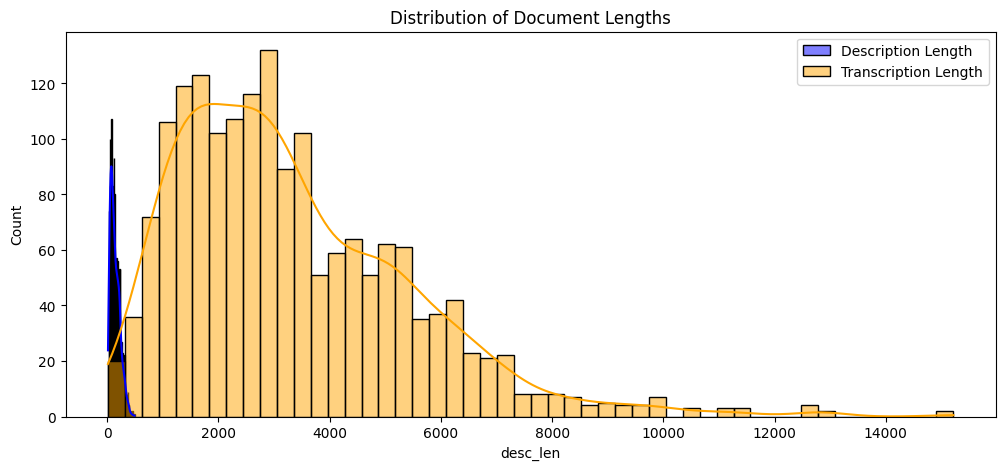

In [4]:
df_train["desc_len"] = df_train["description"].astype(str).apply(len)
df_train["trans_len"] = df_train["transcription"].astype(str).apply(len)

plt.figure(figsize=(12,5))
sns.histplot(df_train["desc_len"], bins=50, kde=True, color="blue", label="Description Length")
sns.histplot(df_train["trans_len"], bins=50, kde=True, color="orange", label="Transcription Length")
plt.legend()
plt.title("Distribution of Document Lengths")
plt.show()

Here we use a chart to see which column is best used for train the model. 
Description doesn't offer much details compared to the transcription therefore Transcription is used as the training set feature.

/var/folders/31/3wlsl_1x2z590whbsw0fm5yr0000gn/T/ipykernel_99356/920369073.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_train["medical_specialty"], order=df_train["medical_specialty"].value_counts().index, palette="viridis")


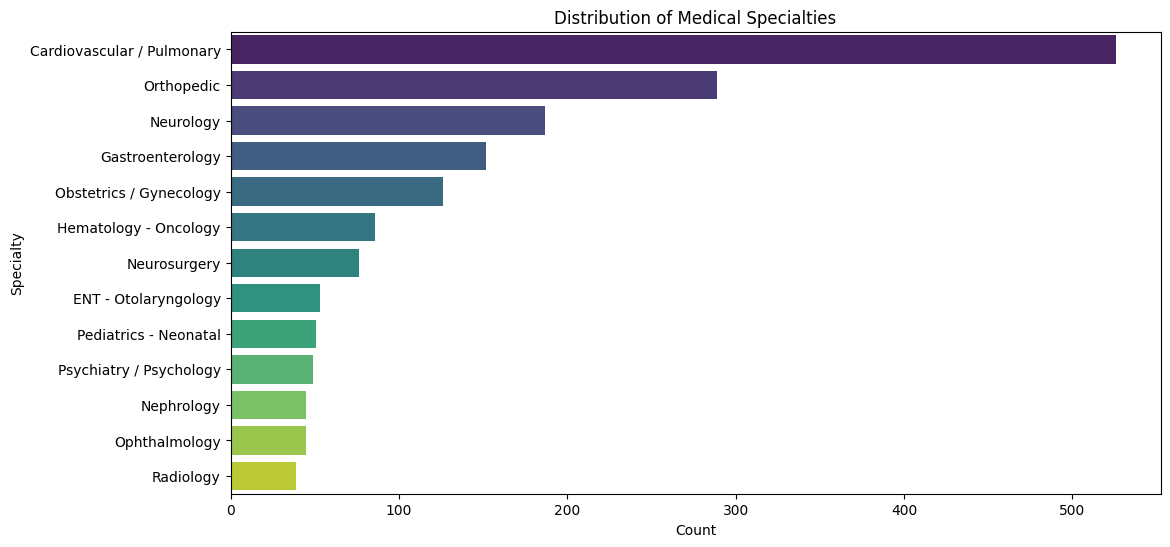

In [5]:
plt.figure(figsize=(12,6))
sns.countplot(y=df_train["medical_specialty"], order=df_train["medical_specialty"].value_counts().index, palette="viridis")
plt.title("Distribution of Medical Specialties")
plt.xlabel("Count")
plt.ylabel("Specialty")
plt.show()

This chart shows that the most cases in the dataset belongs to the Cardiovascular/Pulmonary classification. Therefore the model must be tuned to accurately predict other symptoms and cases.

In [6]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
def preprocess_text(text):
    doc = nlp(str(text).lower())
    tokens = []
    for token in doc:
        if not token.is_stop and not token.is_punct:
            lemma = token.lemma_.strip()
            if lemma:  # skip empty lemmas
                tokens.append(lemma)
    return " ".join(tokens)

df_train["clean_transcription"] = df_train["transcription"].apply(preprocess_text)
df_validation["clean_transcription"] = df_validation["transcription"].apply(preprocess_text)
df_test["clean_transcription"] = df_test["transcription"].apply(preprocess_text)

Here, Spacy is used to lemmatize the dataset into more cleaner versions rather than directly sending the vectorized files. 
- This was done after testing the model first and deciding further adjustments were needed.
- Cleaner transcription is a cleaned version of the original transcription with lemmatized and tokenized

In [7]:

vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range=(1,2),
    max_features=10000
)

#Boost rare classes
ortho_terms = {"fracture", "bone", "joint", "spine"}
neuro_terms = {"seizure", "nerve", "spinal", "brain"}
neurosurg_terms = {"tumor", "craniotomy", "surgery", "lesion"}

specialty_keywords = {
    "Orthopedic": {"fracture", "bone", "joint", "arthroplasty"},
    "Neurology": {"seizure", "epilepsy", "migraine", "neuropathy"},
    "Neurosurgery": {"craniotomy", "aneurysm", "resection", "spinal tumor"},
    "Obstetrics / Gynecology": {"pregnancy", "cervix", "delivery", "menstrual"},
    "Hematology - Oncology": {"chemotherapy", "leukemia", "carcinoma", "oncology"}
}

def boost_keywords(row):
    text = row["clean_transcription"]
    kws = str(row["keywords"]).lower().split()
    boosted = []
    for specialty, terms in specialty_keywords.items():
        for kw in kws:
            if kw in terms:
                boosted.extend([kw] * 8)  # stronger boost
            else:
                boosted.append(kw)
    return text + " " + " ".join(boosted)

# Preprocess once and store
df_train["combined_text"] = df_train["clean_transcription"] + " " + df_train["keywords"].astype(str)
df_validation["combined_text"] = df_validation["clean_transcription"] + " " + df_validation["keywords"].astype(str)
df_test["combined_text"] = df_test["clean_transcription"] + " " + df_test["keywords"].astype(str)

df_train["combined_text"] = df_train.apply(boost_keywords, axis=1)

X_train_vec = vectorizer.fit_transform(df_train["combined_text"])

df_train.to_csv("../resources/df_train_preprocessed.csv", index=False)
df_validation.to_csv("../resources/df_val_preprocessed.csv", index=False)
df_test.to_csv("../resources/df_test_preprocessed.csv", index=False)
# joblib.dump(df_test)


joblib.dump(vectorizer, "../artifacts/vectorizer.joblib")



['../artifacts/vectorizer.joblib']


- `ortho_terms = {"fracture", "bone", "joint", "spine"}
neuro_terms = {"seizure", "nerve", "spinal", "brain"}
neurosurg_terms = {"tumor", "craniotomy", "surgery", "lesion"}` are used here to boost them within the dataset as they are more rare cases
- Then `specialty_keywords` are used to boost and classify even more rare cases and to make sure that the model recognizes different classes differently as much as possioble.
- Then the vectorizer is saved as a joblib file to use with model